In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('../results/result.csv')
df = df[df.run >= 3].copy()
df['speed'] = df['sim-cycles'] / df['time']
df['ipc'] = df['instructions'] / df['cycles']
df['MPKI'] = df['cache-misses'] / df['instructions'] * 1000
df

,simulator,benchmark,sim-cycles,run,time,all_data_cache_accesses,cache-misses,cycles,instructions,speed,ipc,MPKI
3,circt-verilator,RocketCore,10000,3,25695,54922439.0,28891.0,5.153413e+07,1.233300e+08,0.389181,2.393171,0.234258
4,circt-verilator,RocketCore,10000,4,25697,55041598.0,28590.0,5.138309e+07,1.233300e+08,0.389150,2.400206,0.231817
5,circt-verilator,RocketCore,10000,5,26256,55319410.0,28374.0,5.227910e+07,1.233300e+08,0.380865,2.359069,0.230066
6,circt-verilator,RocketCore,10000,6,25377,55025144.0,28639.0,5.110814e+07,1.233301e+08,0.394058,2.413121,0.232214
7,circt-verilator,RocketCore,10000,7,25509,55028825.0,29792.0,5.151930e+07,1.233300e+08,0.392019,2.393860,0.241563
...,...,...,...,...,...,...,...,...,...,...,...,...
745,essent,FMUL,10000,5,1111904,932851472.0,72024506.0,2.441358e+09,1.884002e+09,0.008994,0.771702,38.229525
746,essent,FMUL,10000,6,1117106,933111436.0,73575379.0,2.452644e+09,1.884004e+09,0.008952,0.768152,39.052670
747,essent,FMUL,10000,7,1092786,932711279.0,66320834.0,2.396017e+09,1.884002e+09,0.009151,0.786306,35.202099
748,essent,FMUL,10000,8,1082515,933044933.0,62989970.0,2.376199e+09,1.884001e+09,0.009238,0.792863,33.434153


# Speedup

In [9]:
piv = df.pivot_table(values='speed', index='benchmark', columns='simulator')
order = [
  'SHA256',
  'StreamComp',
  'FMUL',
  'FPU',
  'Gemmini',
  'SIGMA',
  'GEMM',
  'Conv2D',
  'RISCVMini',
  'RocketTile',
  'SodorTile'
]
sim_order = [
  'circt-verilator', 'verilator', 'ksim', 'essent', 'repcut-2', 'vcs'
]
baseline_name = 'circt-verilator'
baseline = piv[baseline_name].copy()
for col in piv:
  piv[col] /= baseline
piv = piv.stack().loc[order].reset_index(name='speedup')
piv = piv.set_index('benchmark').reset_index()
def mark_npos(bar, y, *args, **kws):
  npos = []
  for c in bar.containers:
    for child in c.get_children():
      if np.isnan(child.get_height()):
        center = child.get_x() + child.get_width() / 2
        npos.append(center)
  xlim = plt.xlim()
  plt.plot(npos, np.full(len(npos), y), *args, **kws)
  plt.xlim(xlim)

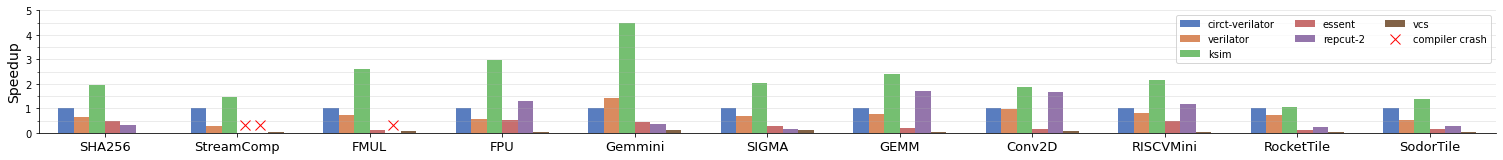

In [10]:
plt.figure(figsize=(22, 2.5))
bar = sns.barplot(
  data=piv,
  x='benchmark', y='speedup',
  hue='simulator', hue_order=sim_order,
  palette='muted',
  width=0.7,
)
# set_hatch(bar)
# for c in bar.containers:
#   bar.bar_label(c, fmt='$%.1f$', fontsize=10)
mark_npos(bar, 0.3, 'rx', markersize=10, label='compiler crash')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=3)
# plt.xticks(fontsize=13, rotation=-15, ha='left')
plt.xticks(fontsize=13)
plt.xlabel(None)
plt.ylim([0, 5])
plt.ylabel('Speedup', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0))
plt.grid(axis='y', alpha=0.3)
plt.grid(axis='y', which='minor', alpha=0.3)
sns.despine()
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.draw()

In [12]:
piv_abs = df.pivot_table(values='speed', columns='simulator', index='benchmark', aggfunc='mean')
baseline_name = 'circt-verilator'
baseline = piv_abs[baseline_name].copy()
piv = piv_abs.apply(lambda x: x / baseline)
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.2f}')

simulator,circt-verilator,essent,ksim,repcut-2,vcs,verilator
benchmark,,,,,,
Conv2D,1.00,0.14,1.88,1.66,0.06,0.96
FMUL,1.00,0.11,2.62,nan,0.08,0.74
FPU,1.00,0.50,2.97,1.29,0.04,0.57
GEMM,1.00,0.21,2.38,1.70,0.05,0.76
Gemmini,1.00,0.44,4.48,0.36,0.11,1.41
RISCVMini,1.00,0.49,2.17,1.19,0.02,0.80
RocketCore,1.00,0.13,1.66,0.26,0.04,0.39
RocketTile,1.00,0.11,1.03,0.22,0.03,0.74
SHA256,1.00,0.47,1.93,0.32,0.00,0.63


# IPC

In [13]:
piv = df.pivot_table(values='ipc', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-2,vcs,verilator
benchmark,,,,,,
Conv2D,1.775,1.215,3.016,1.502,2.560,1.803
FMUL,1.884,0.784,2.944,nan,1.303,2.095
FPU,3.590,2.434,3.566,1.624,2.493,2.767
GEMM,1.732,1.883,2.957,1.442,2.588,1.459
Gemmini,2.941,0.591,3.301,0.523,2.300,2.709
RISCVMini,1.963,2.479,3.300,1.211,2.489,2.197
RocketCore,2.394,1.493,2.986,0.818,2.333,2.409
RocketTile,2.463,1.005,2.922,0.936,2.217,2.199
SHA256,2.813,3.063,3.332,0.448,2.543,2.762


# Cycles

In [14]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [15]:
piv = df.pivot_table(values='cycles', columns='simulator', index='benchmark', aggfunc='mean')
# piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-2,vcs,verilator
benchmark,,,,,,
Conv2D,90.3 M,678.4 M,51.6 M,116.0 M,910.8 M,94.0 M
FMUL,250.5 M,2.4 G,97.6 M,None,2.8 G,342.8 M
FPU,46.4 M,101.3 M,18.4 M,80.5 M,694.8 M,85.0 M
GEMM,66.8 M,336.8 M,31.1 M,86.0 M,910.1 M,89.3 M
Gemmini,1.3 G,2.9 G,283.7 M,7.1 G,10.6 G,896.9 M
RISCVMini,20.8 M,48.2 M,12.2 M,40.9 M,672.0 M,25.8 M
RocketCore,51.5 M,442.3 M,35.0 M,437.6 M,928.9 M,139.3 M
RocketTile,43.3 M,440.1 M,47.1 M,439.9 M,861.7 M,59.7 M
SHA256,4.8 M,7.8 M,3.0 M,32.8 M,621.1 M,6.4 M


# Instructions

In [16]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [17]:
piv = df.pivot_table(values='instructions', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,essent,ksim,repcut-2,vcs,verilator
benchmark,,,,,,
Conv2D,160.1 M,824.1 M,155.5 M,174.2 M,2.3 G,169.4 M
FMUL,472.0 M,1.9 G,287.4 M,None,3.6 G,718.2 M
FPU,166.6 M,246.3 M,65.6 M,130.6 M,1.7 G,235.2 M
GEMM,115.8 M,634.2 M,92.1 M,124.0 M,2.4 G,130.2 M
Gemmini,3.7 G,1.7 G,936.7 M,3.7 G,24.4 G,2.4 G
RISCVMini,40.8 M,119.5 M,40.2 M,49.5 M,1.7 G,56.7 M
RocketCore,123.3 M,660.4 M,104.4 M,357.6 M,2.2 G,335.5 M
RocketTile,106.6 M,442.3 M,137.7 M,411.7 M,1.9 G,131.3 M
SHA256,13.4 M,23.8 M,9.9 M,11.3 M,1.6 G,17.8 M


# MPKI

In [18]:
piv = df.pivot_table(values='MPKI', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,essent,ksim,repcut-2,vcs,verilator
benchmark,,,,,,
Conv2D,0.254,8.179,0.142,5.832,2.157,0.271
FMUL,0.092,35.701,0.077,nan,19.716,0.080
FPU,0.177,0.085,0.281,2.846,1.130,0.123
GEMM,0.261,1.020,0.201,12.597,1.657,0.225
Gemmini,14.433,58.504,7.173,32.209,5.230,7.170
RISCVMini,0.698,0.170,0.463,6.829,1.190,0.563
RocketCore,0.234,0.039,0.175,1.677,1.420,0.090
RocketTile,0.322,0.848,0.147,1.414,1.812,0.246
SHA256,1.860,0.751,1.746,18.452,1.187,1.433
